In [70]:
import pandas as pd
import numpy as np

class Node():
    def __init__(self, n, father='0', child=[]):
        self.n = n
        self.child = child
    def children(self):
        return self.child

class T():
    def __init__(self, sou_tar, root):
        self.sou_tar = sou_tar
        self.root = root
        self.source = list(sou_tar['source'].drop_duplicates().get_values())
        self.target = list(sou_tar['target'].drop_duplicates().get_values())
        self.nodes = np.unique(self.source + self.target)
    def built(self):
        node_list = []
        root_node = Node(self.root)
        child = self.sou_tar['target'][self.sou_tar['source']==self.root]
        if len(child)>0:
            root_node.child = child
        else:
            pass
        return root_node
    def size(self):
        return len(self.nodes)            

In [28]:
def subtree_moments(sou_tar, root):
    Tr = T(sou_tar, root)
    if Tr.size() == 1:
        size = 1
        sum_sizes = 1
        sum_sizes_sqr = 1
    else:
        r = Tr.built()
        size_dic = {}
        sum_sizes_dic = {}
        sum_sizes_sqr_dic = {}
        for c in r.children():
            size_dic[c], sum_sizes_dic[c], sum_sizes_sqr_dic[c] = subtree_moments(sou_tar, c)
        size = 0
        sum_sizes = 0
        sum_sizes_sqr = 0
        for c in r.children():
            size += size_dic[c]
            sum_sizes += sum_sizes_dic[c]
            sum_sizes_sqr += sum_sizes_sqr_dic[c]
        size += 1
        sum_sizes += size
        sum_sizes_sqr += size**2
    return size, sum_sizes, sum_sizes_sqr

def average_distance(sou_tar, root):
    size, sum_sizes, sum_sizes_sqr = subtree_moments(sou_tar, root)
    if size == 1:
        dist_avg = 0
    else:
        dist_avg = (2*size/(size-1))*(sum_sizes/size-sum_sizes_sqr/(size**2))
    return dist_avg

In [3]:
true_news = pd.read_csv('data/true_news.csv')
fake_news = pd.read_csv('data/fake_news.csv')
fake_news.head()

,Unnamed: 0,authorDic,edges,keyUser,layerNum,rpsttimeline,status,weiboID,repost_user_ids,id
0,0,"{'province': '21', 'weiboText': '""【熊孩子驾车引发惨烈车祸...",{'3950782372067939': {'posttime': 'Tue Mar 08 ...,{},"[7, 0, 0, 0, 0, 0]","[['2016-03-08 10:00:00', 0], ['2016-03-08 10:1...",1,3950696707151772,"['2069094965', '1751143994', '3749715145', '58...",5269634098
1,1,"{'province': '400', 'weiboText': '特大新闻，今天某地一桑拿...",{'3950017993116161': {'posttime': 'Sun Mar 06 ...,{'3949751483920081': 'http://tva4.sinaimg.cn/c...,"[169, 103, 9, 4, 0, 0]","[['2016-03-05 13:30:00', 3], ['2016-03-05 13:4...",1,3949660958003450,"['3957883643', '1477623350', '1411110415', '29...",5559568190
2,2,"{'province': '21', 'weiboText': '.. 急找孩子，求转 ...",{},{'3949751483920081': 'http://tva4.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2016-03-07 22:10:00', 0], ['2016-03-07 22:2...",1,3950515929249677,[],1692637037
3,3,"{'province': '44', 'weiboText': '急找孩子，求转 实验小学...",{},{'3949751483920081': 'http://tva4.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2016-03-07 21:50:00', 0], ['2016-03-07 22:0...",1,3950512342047569,[],2211424651
4,4,"{'province': '13', 'weiboText': '急找孩子，求转 寻人启事 ...",{},{'3949751483920081': 'http://tva4.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2016-03-07 20:10:00', 0], ['2016-03-07 20:2...",1,3950485830376193,[],2145377515


In [4]:
import re
patt_edge= '\'(.*?)\': {.*?\'repostedid\': \'(.*?)\',.*?}'
def findall_edge(data, patt):
    result = re.findall(patt,data)
    sou_tar = pd.DataFrame(result, columns=['target', 'source'])
    return sou_tar

In [ ]:
true_news['sou_tar'] = true_news['edges'].apply(lambda s: findall_edge(s, patt_edge))
fake_news['sou_tar'] = fake_news['edges'].apply(lambda s: findall_edge(s, patt_edge))

In [71]:
average_distance(fake_news['sou_tar'][1], '3949660958003450')

2.7565206723101463

In [78]:
true_news['struc_virality'] = true_news.apply(lambda s: average_distance(s['sou_tar'], str(s['weiboID'])), axis=1)
fake_news['struc_virality'] = fake_news.apply(lambda s: average_distance(s['sou_tar'], str(s['weiboID'])), axis=1)

In [82]:
import ast

true_news['repostNum'] = true_news['authorDic'].apply(lambda info: ast.literal_eval(info)['repostNum'])
fake_news['repostNum'] = fake_news['authorDic'].apply(lambda info: ast.literal_eval(info)['repostNum'])

In [85]:
true_news['struc_virality'][true_news['repostNum']<10].describe()

count    8255.000000
mean        0.553373
std         0.701503
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.055556
Name: struc_virality, dtype: float64

In [86]:
fake_news['struc_virality'][fake_news['repostNum']<10].describe()

count    16318.000000
mean         0.433163
std          0.700064
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.333333
Name: struc_virality, dtype: float64

In [87]:
true_news['struc_virality'][true_news['repostNum']>=10].describe()

count    1745.000000
mean        2.375547
std         0.581990
min         1.818182
25%         1.997980
50%         2.167320
75%         2.551718
max         7.142302
Name: struc_virality, dtype: float64

In [88]:
fake_news['struc_virality'][fake_news['repostNum']>=10].describe()

count    6161.000000
mean        3.251625
std         1.130913
min         1.818182
25%         2.395915
50%         2.969014
75%         3.834382
max         9.894752
Name: struc_virality, dtype: float64

In [171]:
# true_news.groupby('repostNum').mean().index.get_values()

In [115]:
fake_news.groupby('repostNum').mean().index.get_values()

array([   0,    1,    2, ..., 1992, 1993, 1998], dtype=int64)

In [104]:
true_news['label'] = 'true'
fake_news['label'] = 'fake'
news = true_news.append(fake_news)
news = news.reset_index(drop=True)
news.drop(['sou_tar'],axis=1).to_csv('data/struc_virality.csv', index=False)

In [13]:
import matplotlib.pyplot as plt
def plot_sv(T, F, column):
    labels = ['T news', 'F news']
    news_list = [T, F]
    plt.style.use('seaborn-white')
    for i in range(2):
        x = news_list[i].groupby('repostNum').mean().index.get_values()
        y = news_list[i].groupby('repostNum').mean()[column]
        plt.scatter(x,y, label=labels[i])
    plt.xscale('log')
    plt.axhline(y=2, lw=3, c='lightgrey')
    plt.axvline(x=1e1, lw=3, c='lightgrey')
    plt.xlim(1e0,1e3)
    plt.legend()
    plt.show()

In [1]:
import networkx
import pandas as pd
import numpy as np

news = pd.read_csv('data/struc_virality.csv')
news.head()

,Unnamed: 0,authorDic,edges,keyUser,layerNum,rpsttimeline,status,weiboID,repost_user_ids,id,struc_virality,repostNum,label
0,0,"{'province': '11', 'weiboText': '远去的大师', 'scre...",{},{'4010120209906916': 'http://tva3.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2014-12-31 22:50:00', 0], ['2014-12-31 23:0...",1,3793976291216967,[],1943724947,0.000000,0,true
1,1,"{'province': '11', 'weiboText': '中国青年女科学家奖十周年纪...",{'3658686746755393': {'posttime': 'Mon Dec 23 ...,{'4010120209906916': 'http://tva3.sinaimg.cn/c...,"[2, 0, 0, 0, 0, 0]","[['2013-12-18 11:00:00', 1], ['2013-12-18 11:1...",1,3656813583185243,"['3880085981', '1098289271']",1791353831,1.333333,2,true
2,2,"{'province': '11', 'weiboText': '【民办教师首次纳入职评体系...",{},{'4006787155492653': 'http://tva3.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2016-04-19 09:00:00', 0], ['2016-04-19 09:1...",1,3965901743766209,[],1864313207,0.000000,0,true
3,3,"{'province': '22', 'weiboText': '转发微博', 'scree...",{},{'4010300573400632': 'http://tva1.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2016-02-23 09:10:00', 0], ['2016-02-23 09:2...",1,3945608626241268,[],1765230662,0.000000,0,true
4,4,"{'province': '64', 'weiboText': '转发微博', 'scree...",{},{'4010300573400632': 'http://tva1.sinaimg.cn/c...,"[0, 0, 0, 0, 0, 0]","[['2016-08-19 09:50:00', 0], ['2016-08-19 10:0...",1,4010124030948666,[],1882632930,0.000000,0,true


In [6]:
import re
import networkx as nx
patt_edge= '\'(.*?)\': {.*?\'repostedid\': \'(.*?)\',.*?}'
def struc_varility_net(data, patt):
    tar_sou = re.findall(patt,data)
    G = nx.Graph()
    G.add_edges_from(tar_sou)
    if len(G.nodes())>1:
        v = nx.average_shortest_path_length(G)
    else:
        v = 0
    return v
struc_varility_net(news['edges'][1], patt_edge)

1.3333333333333333

In [8]:
struc_varility_net(news['edges'][7], patt_edge)

1.6

In [10]:
news['struc_varility_net'] = news['edges'].apply(lambda s: struc_varility_net(s, patt_edge))

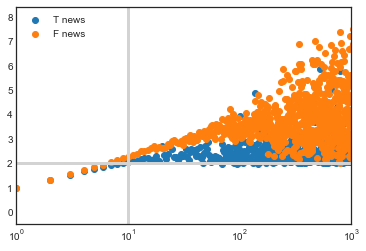

In [14]:
plot_sv(news[news['label']=='true'],news[news['label']=='fake'], 'struc_varility_net')

In [15]:
news.to_csv('data/struc_varility_net.csv', index=False)